# Hilbert-Schmidt Independence Criterion (HSIC)

In [1]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.linear import Linear
from jaxkern.similarity.hsic import HSIC, CKA, HSICRBF, CKARBF
from jaxkern.kernels.sigma import estimate_sigma_median

from jaxkern.data.similarity import generate_data

# 
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

/Users/eman/miniconda3/envs/jaxkern/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


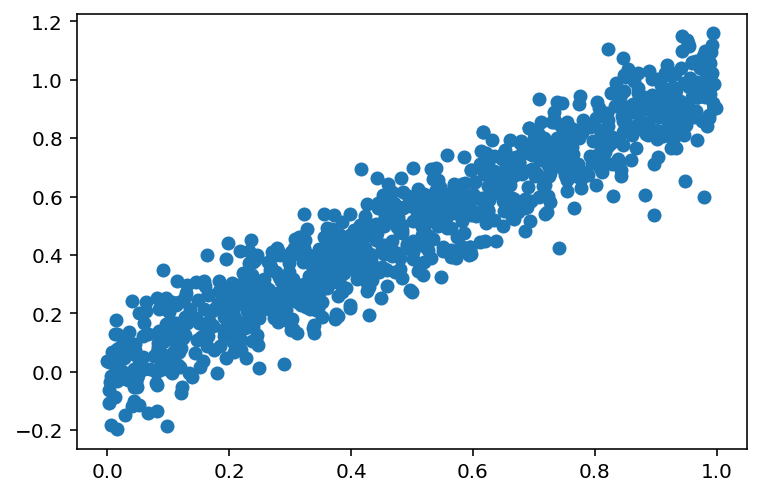

In [2]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 1_000
noise_y = 0.1

X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## HSIC - From Scratch

#### 1. Calculate Kernel Matrices

In [26]:
from jaxkern.kernels.approx import RBFSampler
# initialize kernel
n_rff = 100
center = True

# calculate X kernel matrix
length_scale = estimate_sigma_median(X, X)
rff_kern = RBFSampler(n_rff=n_rff, length_scale=length_scale, center=center)
Z_x = rff_kern(X)

# calculate Y kernel matrix
length_scale = estimate_sigma_median(Y, Y)
rff_kern = RBFSampler(n_rff=n_rff, length_scale=length_scale, center=center)
Z_y = rff_kern(Y)

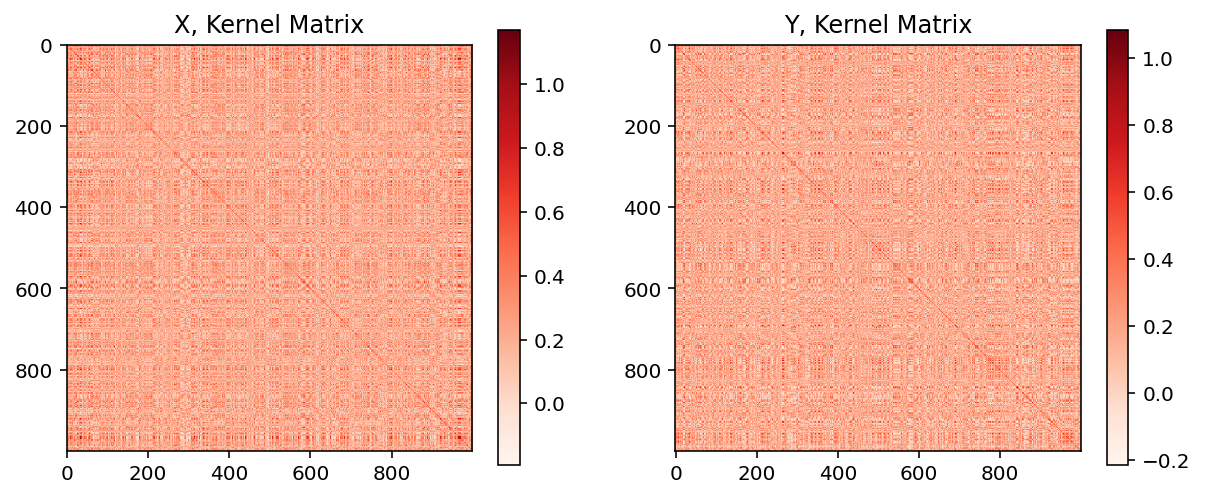

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(Z_x.T @ Z_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(Z_y.T @ Z_y, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

#### 2. Center Kernel Matices

Kernel Centerer:
$$\text{H}=\mathbf{I}_N - \left( \frac{1}{N}\right)\mathbb{1}_N$$

#### 3. Summarize: HSIC Norm

Here we implement the HSIC norm which is a way to summarize the information with the matrices.

$$
\text{HSIC}(\mathbf{X}, \mathbf{Y}) = \langle \tilde{K}_x, \tilde{K}_y \rangle_{\text{HS}}
$$

* https://github.com/oxmlcs/kerpy/blob/master/independence_testing/HSICTestObject.py
* https://link.springer.com/article/10.1007/s11222-016-9721-7
* https://papers.nips.cc/paper/6180-learning-kernels-with-random-features.pdf
* https://arxiv.org/pdf/2004.11154.pdf
* https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py
* https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy

In [196]:
from jaxkern.kernels.approx import RBFSampler
# initialize kernel
n_samples = X.shape[0]
n_rff = 50
center = True

# calculate X kernel matrix
length_scale = estimate_sigma_median(X, X)
rff_kern = RBFSampler(n_rff=n_rff, length_scale=length_scale, center=center)
Z_x = rff_kern(X)

# calculate Y kernel matrix
length_scale = estimate_sigma_median(Y, Y)
rff_kern = RBFSampler(n_rff=n_rff, length_scale=length_scale, center=center)
Z_y = rff_kern(Y)

In [197]:
def hsic_v_stat_rff(Zx, Zy):
    
    # number of samples
    n_samples = Zx.shape[0]
    
    # Center datasets
    Zx = Zx - Zx.mean(axis=0)
    Zy = Zy - Zy.mean(axis=0)
    
    # calculate feature covariance
    feat_cov = np.dot(Zx.T, Zy) / n_samples
    
    # find Hsic measure
    return np.linalg.norm(feat_cov)**2

In [198]:
rff_hsic_val = hsic_v_stat_rff(Z_x, Z_y)
print(f"rHSIC (normalized): {rff_hsic_val:.4f}")

rHSIC (normalized): 6.9752


In [199]:
def normalized_hsic_rff(Zx, Zy):
    A = hsic_v_stat_rff(Zx, Zy)
    B = hsic_v_stat_rff(Zx, Zx)
    C = hsic_v_stat_rff(Zy, Zy)
    return A / np.sqrt(B * C)

In [200]:
rff_nhsic_val = normalized_hsic_rff(Z_x, Z_y)
print(f"rHSIC (normalized): {rff_nhsic_val:.4f}")

rHSIC (normalized): 0.1525


In [145]:
# calculate the Rxy
Rxy = Z_x @ Z_y.T

rffhsic_value = np.linalg.norm(Rxy / n_samples)
print(f"aHSIC: {rffhsic_value:.4f}")

aHSIC: 0.2159


#### Gustau's Paper

In [146]:
ahsic_value = np.trace(Z_x.T.dot(Z_x).dot(Z_y.T).dot(Z_y))

ahsic_value *= 1 / (n_samples**2)
print(f"aHSIC: {ahsic_value:.4f}")

aHSIC: 0.0466


In [110]:
n

DeviceArray(0.67790717, dtype=float32)

In [ ]:
Rxx = Z_x @ Z_x.T
Ryy = Z_y @ Z_y.T

np.sum(Rxy * Rxy) / np.linalg.norm(Rxx) / np.linalg.norm(Ryy)

In [65]:
Rx 

ahsic_value = np.trace(Z_x.T.dot(Z_x).dot(Z_y.T).dot(Z_y))
print(f"aHSIC: {ahsic_value:.4f}")

aHSIC: 91479.4062


In [66]:
Rxx = Z_x.T.dot(Z_x)
Ryy = Z_y.T.dot(Z_y)

ahsic_value = np.sum(Rxx * Ryy)
print(f"rHSIC: {ahsic_value:.4f}")

rHSIC: 91479.4062


In [94]:
np.sum(np.dot(Z_x, Z_x.T) * np.dot(Z_y, Z_y.T))

DeviceArray(7727.2227, dtype=float32)

In [67]:
bias = 1 / (Rxx.shape[0]**2)

ahsic_val_s = bias * ahsic_value

print(f"aHSIC: {ahsic_val_s:.4f}")

aHSIC: 0.0915


In [77]:

A = np.sum(Rxx * Ryy)
B = np.linalg.norm(Rxx)
C = np.linalg.norm(Ryy)

nahsic_value = A / B / C

print(f"aHSIC (normalized): {nahsic_value:.4f}")
print(A, B, C)

aHSIC (normalized): 0.6216
91479.41 393.50473 373.9754


### More Efficient


$$
RHSIC() = factor \left(\tilde{Z}_x\tilde{Z}_x^{\top} \tilde{Z}_y\tilde{Z}_y^{\top} \right)
$$

$$
RHSIC() = factor \left(\tilde{Z}_x^{\top}\tilde{Z}_y \tilde{Z}_y^{\top}\tilde{Z}_x \right)
$$

In [88]:
np.sum(Z_x.dot(Z_x.T) * Z_y.dot(Z_y.T))

DeviceArray(7727.2227, dtype=float32)

In [80]:
A = np.trace(np.dot(Z_x, Z_y.T) @ np.dot(Z_y, Z_x.T))

print(f"rHSIC: {A:.4f}")

rHSIC: 91479.3984


In [83]:
B = np.linalg.norm(np.dot(Z_x, Z_x.T))
C = np.linalg.norm(np.dot(Z_y, Z_y.T))

print(A, B, C)

91479.4 393.50476 373.97537


In [86]:
np.dot(Z_x.T, Z_x).shape, np.dot(Z_x, Z_x.T).shape

((1000, 1000), (100, 100))

In [84]:
B = np.linalg.norm(np.dot(Z_x.T, Z_x))
C = np.linalg.norm(np.dot(Z_y, Z_y.T))

print(A, B, C)

91479.4 393.50473 373.97537


In [70]:


rhsic_value = np.sum(Rxy * Ryx)
print(f"rHSIC: {rhsic_value:.4f}")

rHSIC: 119.9357


In [51]:
onp.testing.assert_array_almost_equal(onp.array(Z_x.dot(Z_y.T)), onp.array(Z_y.dot(Z_x.T)))

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 9900 / 10000 (99%)
Max absolute difference: 24.587982
Max relative difference: 8752.372
 x: array([[ 0.940105, -0.401783, -2.473529, ...,  7.057935, -2.655214,
         0.441997],
       [-8.493301,  0.162888, -0.990684, ..., -4.167835,  7.286853,...
 y: array([[ 0.940105, -8.493301, -1.143529, ..., -2.365393, -0.508657,
         3.460225],
       [-0.401783,  0.162888,  0.158586, ..., -0.081801,  0.557684,...

In [ ]:
bias = 1 / (Rxx.shape[0]**2)

hsic_val_s = bias * hsic_value

print(f"HSIC: {hsic_val_s:.4f}")

In [50]:
%timeit np.trace(Z_x.T.dot(Z_x).dot(Z_y.T).dot(Z_y))
%timeit np.trace(Z_x.dot(Z_y.T).dot(Z_y).dot(Z_x.T))

10.3 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.67 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


DeviceArray(91479.41, dtype=float32)

In [40]:
Rxy = np.dot(Z_x, Z_y.T)
Ryx = np.dot(Z_y, Z_x.T)


print(Rxy.shape, Ryx.shape)

(100, 100) (100, 100)


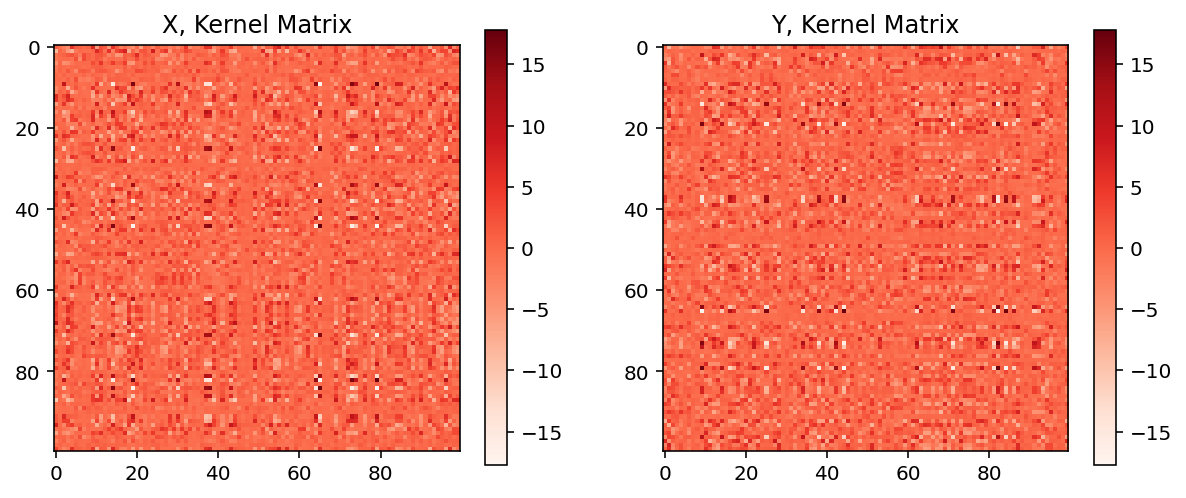

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(Rxy, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(Ryx, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

In [32]:
Rxy.min(), Rxy.max()

(DeviceArray(-17.748096, dtype=float32), DeviceArray(17.78858, dtype=float32))

In [33]:
Z_x.shape

(100, 1000)

In [34]:
rhsic_value = np.sum(Rxy * Rxy.T)

print(f"rHSIC: {rhsic_value:.4f}")

rHSIC: 119.9357


#### 4. Bias Terms

In [36]:
bias = 1 / (Z_x.shape[1]**2)

rhsic_value = bias * rhsic_value

print(f"HSIC: {rhsic_value:.2e}")

HSIC: 1.20e-10


#### 5. Normalize

So it's very difficult to interpret HSIC in terms of similarity. It's similar to the covariance matrix, we need to normalize by the sizes of the individual matrices.

In [38]:
np.linalg.norm(Rxy), np.linalg.norm(Rxy.T)

(DeviceArray(302.45563, dtype=float32), DeviceArray(302.45563, dtype=float32))

In [37]:
nhsic_value = np.sum(Rxy * Rxy.T) / np.linalg.norm(Rxy) / np.linalg.norm(Rxy.T)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.0013


### Linear Kernel

In [10]:
kernel = Linear()

hsic_clf = HSIC(kernel, kernel, bias=True)

hsic_val = hsic_clf(X, Y)


print(f"HSIC: {hsic_val:.4f}")
# calculate hsic value

HSIC: 0.0068


### RBF Kernel

In [11]:
# estimate sigma
σ_x = estimate_sigma_median(X, X)
σ_y = estimate_sigma_median(Y, Y)

print(f"σ_x: {σ_x:.4f}" )
print(f"σ_y: {σ_y:.4f}" )

# calculate kernel matrices
kernel_X = RBF(variance=1.0, length_scale=σ_x)
kernel_Y = RBF(variance=1.0, length_scale=σ_y)

σ_x: 0.0838
σ_y: 0.0945


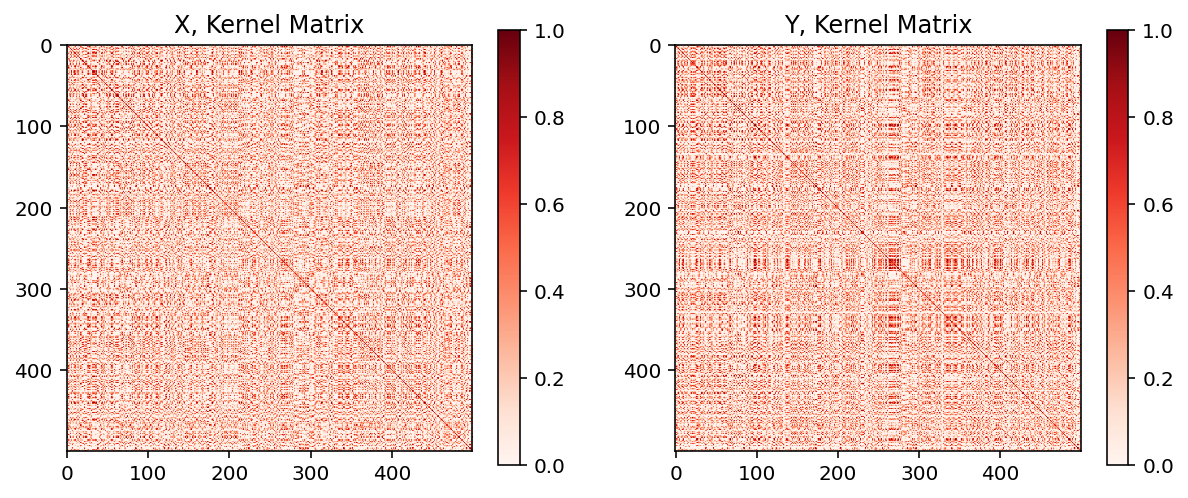

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(kernel_X(X,X), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(kernel_Y(Y, Y), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

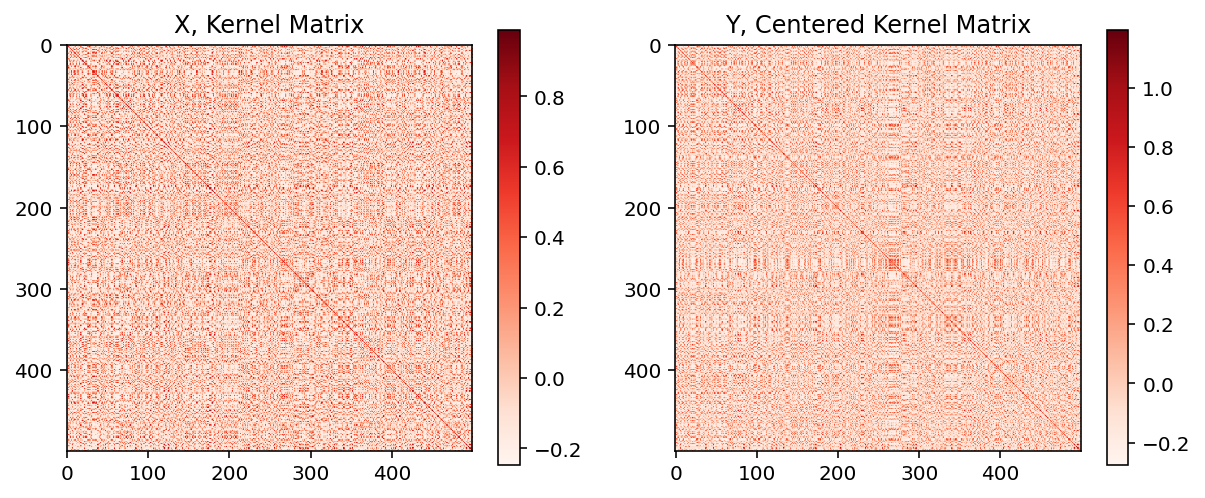

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(centering(kernel_X(X,X)), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(centering(kernel_Y(Y,Y)), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Centered Kernel Matrix")
plt.show()

In [14]:
# initialize HSIC model
hsic_clf = CKA(kernel_X, kernel_Y, bias=True)

# calculate HSIC
hsic_val = hsic_clf(X, Y)
print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.5489


#### Convenience Function

Let's be honest, most people are going to use the RBF kernel. It's universal, quick n dirty, and quite simple to interpretate. So I made a convenience function to help people deal with it.

In [15]:
sigma_f = estimate_sigma_median

nhsic_clf = CKARBF(sigma_f, sigma_f)

nhsic_value = nhsic_clf(X, Y)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.5489


## Other Datasets

### Non-Linear

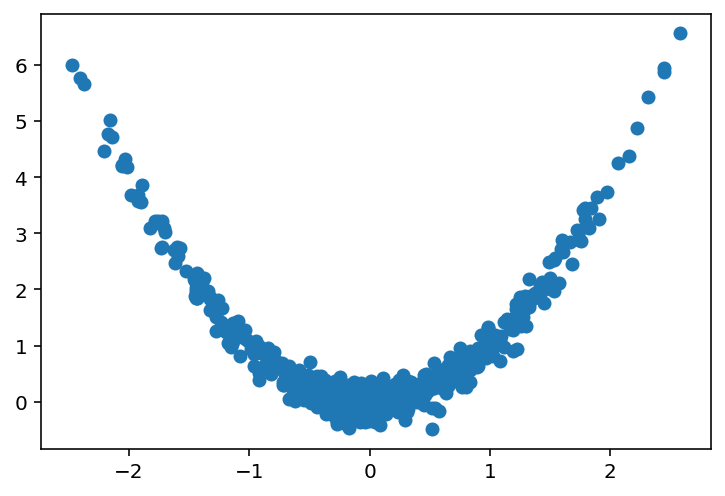

In [16]:
X = onp.random.randn(n_samples, 1)
Y = X**2 + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

#### Linear Kernel

In [17]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0018


#### RBF Kernel

In [18]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.4132


### Periodic

In [19]:
X = np.abs(2 * onp.random.randn(n_samples, 1))
Y = np.sin(X) + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

#### Linear Kernel

In [20]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.2029


#### RBF Kernel

In [21]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.1840


### Circle

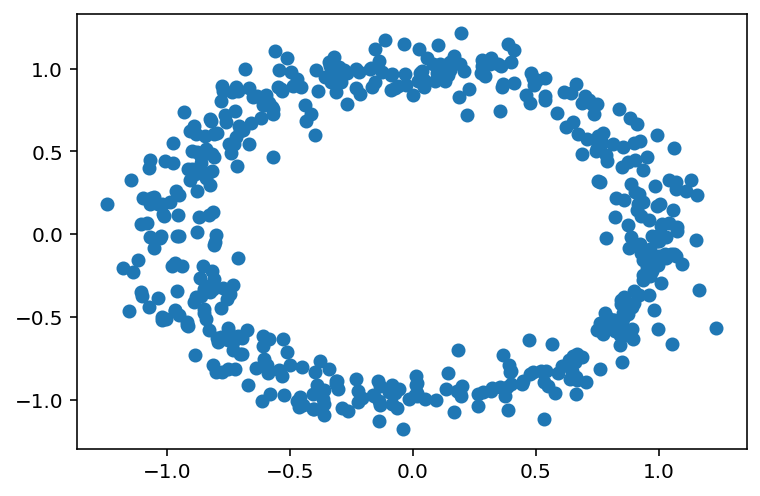

In [22]:
X, Y = generate_data(n_samples, "circle", noise_y=0.1, noise_x=0.1)

plt.scatter(X, Y)

#### Linear Kernel

In [23]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0006


#### RBF Kernel

In [24]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.1128


### Random

In [25]:
X, Y = generate_data(n_samples, "random", noise_y=noise_y)

#### Linear Kernel

In [26]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0029


#### RBF Kernel

In [27]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.0167


## MMD Equivalent

In [28]:
X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

In [29]:
# linear kernel
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

# center matrices
K_xc = centering(K_x)
K_yc = centering(K_y)

In [30]:
# get the expectrations
A = np.mean(K_xc * K_yc)
B = np.mean(np.mean(K_xc, axis=0) * np.mean(K_yc, axis=0))
C = np.mean(K_xc) * np.mean(K_yc)

In [31]:
print(f"A: {A:.2e}")
print(f"B: {B:.2e}")
print(f"C: {C:.2e}")

A: 6.84e-03
B: -1.03e-16
C: -3.26e-19


In [32]:
# calculate MMD
mmd_value = A - 2 * B + C

print(f"MMD: {mmd_value:.4f}")

MMD: 0.0068
